# Plant Leaf Disease Detection
Mayur Kr. Garg

## Imports

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Dense, Concatenate, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
from model_utility import plot_images

In [2]:
tf.__version__

'2.11.0'

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices

[]

In [3]:
tf.get_logger().setLevel('ERROR')

## Constants

### Data

In [1]:
import os
BASE_DIR = r"C:\Users\SAI SURYA\Downloads\New Plant Diseases Dataset Augmented"
tEST_DIR =r"C:\Users\SAI SURYA\Downloads\New Plant Diseases Dataset Augmented\test"
TRAIN_DIR = os.path.join(BASE_DIR, "train1")
VAL_DIR = os.path.join(BASE_DIR, "valid1")
TEST_DIR = os.path.join(tEST_DIR, "test")
IMG_SHAPE  = (256, 256)
BATCH_SIZE = 64

### Model

In [2]:
INPUT_DEPTH_MULTIPLIER = 8
BASE_FILTER_COUNT = 32
DENSE_NODES = 512
DROPOUT_PERCENTS = [0.2, 0.2]

### Training

In [7]:
EPOCHS = 20
PATIENCE = 5
QUEUE_SIZE = 25
TB_LOGS = "tensorboard_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
PLOTS_DPI = 200

## Data Loading

### Data Distribution

#### Train

In [8]:
total_train = 0

for d in os.listdir(TRAIN_DIR):
    path = os.path.join(TRAIN_DIR, d)
    img_count = len(os.listdir(path))
    total_train += img_count
    print(f'{d:50} : {img_count}')

print(f'\nTotal training images: {total_train}')

Apple___Apple_scab                                 : 2016
Apple___Black_rot                                  : 1987
Apple___Cedar_apple_rust                           : 1760
Apple___healthy                                    : 2008
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot : 1642
Corn_(maize)___Common_rust_                        : 1907
Corn_(maize)___healthy                             : 1859
Corn_(maize)___Northern_Leaf_Blight                : 1908
Potato___Early_blight                              : 1939
Potato___healthy                                   : 1824
Tomato___Early_blight                              : 1920
Tomato___healthy                                   : 1926
Tomato___Leaf_Mold                                 : 1882
Tomato___Septoria_leaf_spot                        : 1745
Tomato___Spider_mites Two-spotted_spider_mite      : 1741
Tomato___Target_Spot                               : 1827
Tomato___Tomato_mosaic_virus                       : 1790
Tomato___Tomat

#### Validation

In [9]:
total_val = 0

for d in os.listdir(VAL_DIR):
    path = os.path.join(VAL_DIR, d)
    img_count = len(os.listdir(path))
    total_val += img_count
    print(f'{d:50} : {img_count}')

print(f'\nTotal validation images: {total_val}')

Apple___Apple_scab                                 : 504
Apple___Black_rot                                  : 497
Apple___Cedar_apple_rust                           : 440
Apple___healthy                                    : 502
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot : 410
Corn_(maize)___Common_rust_                        : 477
Corn_(maize)___healthy                             : 465
Corn_(maize)___Northern_Leaf_Blight                : 477
Potato___Early_blight                              : 485
Potato___healthy                                   : 456
Tomato___Early_blight                              : 480
Tomato___healthy                                   : 481
Tomato___Leaf_Mold                                 : 470
Tomato___Septoria_leaf_spot                        : 436
Tomato___Spider_mites Two-spotted_spider_mite      : 435
Tomato___Target_Spot                               : 457
Tomato___Tomato_mosaic_virus                       : 448
Tomato___Tomato_Yellow_Leaf_Cur

#### Test

In [6]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array, ImageDataGenerator
import numpy as np
test_image_data = []
test_image_filenames = []

for img_name in os.listdir(TEST_DIR):
    img = load_img(os.path.join(TEST_DIR, img_name), target_size = IMG_SHAPE)
    test_image_data.append(img_to_array(img, dtype = 'uint8'))
    test_image_filenames.append(img_name)
    print(img_name)
    
test_image_data = np.array(test_image_data)/255
print(f'\nTotal testing images: {len(test_image_data)}')

AppleCedarRust2.JPG
AppleCedarRust4.JPG
PotatoEarlyBlight4.JPG
PotatoHealthy1.JPG
TomatoYellowCurlVirus3.JPG
TomatoYellowCurlVirus6.JPG

Total testing images: 6


### Image Generators

#### Train

In [12]:
train_image_gen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 15,
        width_shift_range = 0.05,
        height_shift_range = 0.05,
        shear_range = 0.05,
        zoom_range = 0.05,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode = 'reflect'
    )

train_data_gen = train_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = TRAIN_DIR,
        shuffle = True,
        target_size = IMG_SHAPE
    )

Found 33642 images belonging to 18 classes.


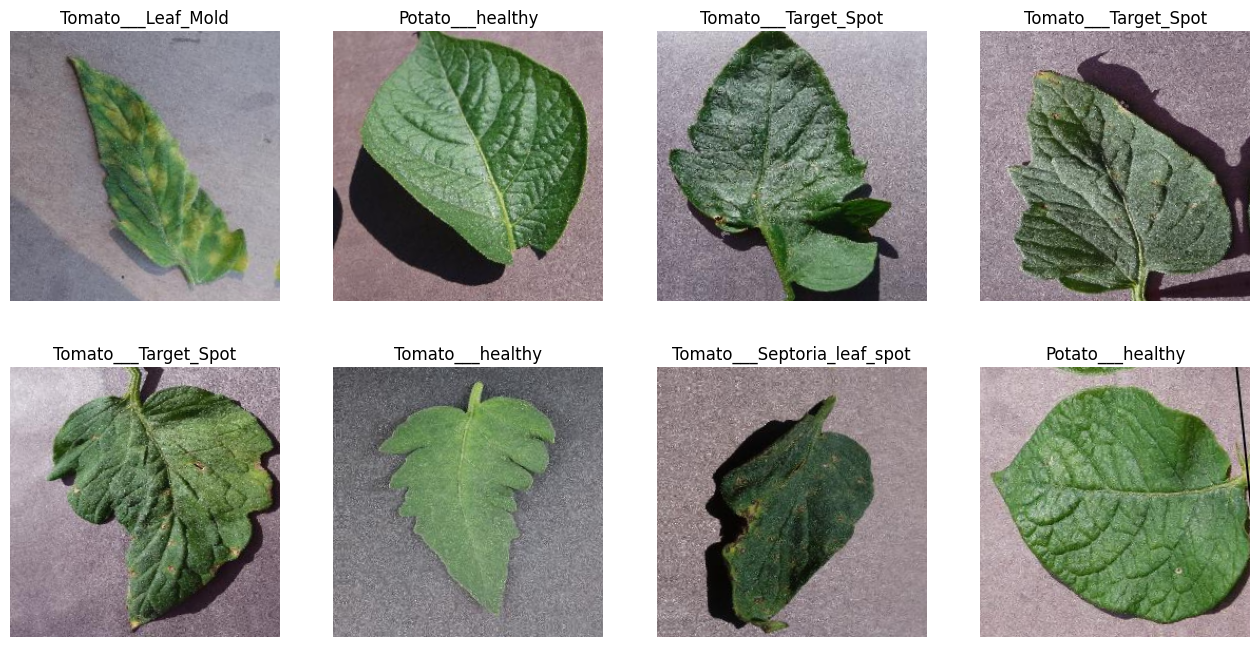

In [13]:
plot_images(train_data_gen)

#### Validation

In [14]:
val_image_gen = ImageDataGenerator(rescale = 1./255)

val_data_gen = val_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = VAL_DIR,
        shuffle = True,
        target_size = IMG_SHAPE
    )

Found 8410 images belonging to 18 classes.


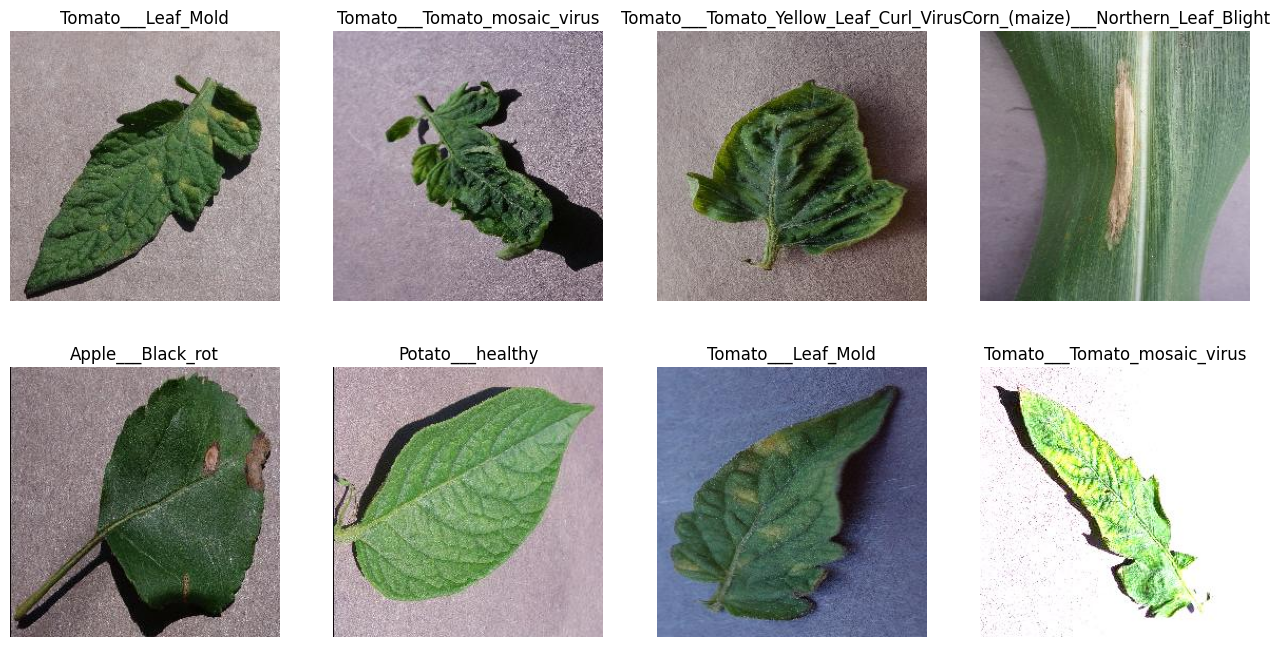

In [15]:
plot_images(val_data_gen)

### Class lookup dictionary

In [16]:
total_classes = len(os.listdir(TRAIN_DIR))

print(f'\nTotal number of classes: {total_classes}')


Total number of classes: 18


In [17]:
class_name_lookup = {name: index for index, name in train_data_gen.class_indices.items()}

for k, v in class_name_lookup.items():
    print(f"{k:2} : {v}")

 0 : Apple___Apple_scab
 1 : Apple___Black_rot
 2 : Apple___Cedar_apple_rust
 3 : Apple___healthy
 4 : Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
 5 : Corn_(maize)___Common_rust_
 6 : Corn_(maize)___Northern_Leaf_Blight
 7 : Corn_(maize)___healthy
 8 : Potato___Early_blight
 9 : Potato___healthy
10 : Tomato___Early_blight
11 : Tomato___Leaf_Mold
12 : Tomato___Septoria_leaf_spot
13 : Tomato___Spider_mites Two-spotted_spider_mite
14 : Tomato___Target_Spot
15 : Tomato___Tomato_Yellow_Leaf_Curl_Virus
16 : Tomato___Tomato_mosaic_virus
17 : Tomato___healthy


## Model

### Input Layer

In [18]:
inputs = tf.keras.Input(shape = (*IMG_SHAPE, 3), name = "Input")
inputs.shape

TensorShape([None, 256, 256, 3])

### Depthwise Convolution + Pointwise Convolution + Max Pooling blocks

#### Block 1

In [19]:
depth_conv_1 = DepthwiseConv2D(2, depth_multiplier = INPUT_DEPTH_MULTIPLIER, padding = "same", activation = "relu", name = "DwC_1")(inputs)
depth_conv_1.shape

TensorShape([None, 256, 256, 24])

In [20]:
point_conv_1 = Conv2D(BASE_FILTER_COUNT, 1, activation = "relu", name = "PwC_1")(depth_conv_1)
point_conv_1.shape

TensorShape([None, 256, 256, 32])

In [21]:
max_pool_1 = MaxPooling2D(name = "MP_1")(point_conv_1)
max_pool_1.shape

TensorShape([None, 128, 128, 32])

#### Block 2

In [22]:
depth_conv_2 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_2")(max_pool_1)
depth_conv_2.shape

TensorShape([None, 128, 128, 32])

In [23]:
point_conv_2 = Conv2D(BASE_FILTER_COUNT * 2, 1, activation = "relu", name = "PwC_2")(depth_conv_2)
point_conv_2.shape

TensorShape([None, 128, 128, 64])

In [24]:
max_pool_2 = MaxPooling2D(name = "MP_2")(point_conv_2)
max_pool_2.shape

TensorShape([None, 64, 64, 64])

#### Block 3

In [25]:
depth_conv_3 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_3")(max_pool_2)
depth_conv_3.shape

TensorShape([None, 64, 64, 64])

In [26]:
point_conv_3 = Conv2D(BASE_FILTER_COUNT * 4, 1, activation = "relu", name = "PwC_3")(depth_conv_3)
point_conv_3.shape

TensorShape([None, 64, 64, 128])

In [27]:
max_pool_3 = MaxPooling2D(name = "MP_3")(point_conv_3)
max_pool_3.shape

TensorShape([None, 32, 32, 128])

#### Block 4

In [28]:
depth_conv_4 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_4")(max_pool_3)
depth_conv_4.shape

TensorShape([None, 32, 32, 128])

In [29]:
point_conv_4 = Conv2D(BASE_FILTER_COUNT * 8, 1, activation = "relu", name = "PwC_4")(depth_conv_4)
point_conv_4.shape

TensorShape([None, 32, 32, 256])

In [30]:
max_pool_4 = MaxPooling2D(name = "MP_4")(point_conv_4)
max_pool_4.shape

TensorShape([None, 16, 16, 256])

#### Block 5

In [31]:
depth_conv_5 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_5")(max_pool_4)
depth_conv_5.shape

TensorShape([None, 16, 16, 256])

In [32]:
point_conv_5 = Conv2D(BASE_FILTER_COUNT * 16, 1, activation = "relu", name = "PwC_5")(depth_conv_5)
point_conv_5.shape

TensorShape([None, 16, 16, 512])

In [34]:
max_pool_5 = MaxPooling2D(name = "MP_5")(point_conv_5)
max_pool_5.shape

TensorShape([None, 8, 8, 512])

### Global Average Pooling layers for each block

In [35]:
global_avg_1 = GlobalAveragePooling2D(name = "GAP_1")(max_pool_1)
global_avg_1.shape

TensorShape([None, 32])

In [36]:
global_avg_2 = GlobalAveragePooling2D(name = "GAP_2")(max_pool_2)
global_avg_2.shape

TensorShape([None, 64])

In [37]:
global_avg_3 = GlobalAveragePooling2D(name = "GAP_3")(max_pool_3)
global_avg_3.shape

TensorShape([None, 128])

In [38]:
global_avg_4 = GlobalAveragePooling2D(name = "GAP_4")(max_pool_4)
global_avg_4.shape

TensorShape([None, 256])

In [39]:
global_avg_5 = GlobalAveragePooling2D(name = "GAP_5")(max_pool_5)
global_avg_5.shape

TensorShape([None, 512])

### Concatenation Layer

In [40]:
concatenated = Concatenate(name = "Concat")([global_avg_1, global_avg_2, global_avg_3, global_avg_4, global_avg_5])
concatenated.shape

TensorShape([None, 992])

### Dropout and Dense Layers

In [41]:
dropout_1 = Dropout(DROPOUT_PERCENTS[0], name = "Droput_1")(concatenated)
dropout_1.shape

TensorShape([None, 992])

In [42]:
dense_1 = Dense(DENSE_NODES, activation = "relu", name = "Dense_1")(dropout_1)
dense_1.shape

TensorShape([None, 512])

In [43]:
dropout_2 = Dropout(DROPOUT_PERCENTS[1], name = "Dropout_2")(dense_1)
dropout_2.shape

TensorShape([None, 512])

In [44]:
dense_2 = Dense(total_classes, activation = "softmax", name = "Output")(dropout_2)
dense_2.shape

TensorShape([None, 18])

### Model Summary

In [45]:
model = Model(inputs = inputs, outputs = dense_2, name = "Plant_Leaf")

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
 
model.summary()

Model: "Plant_Leaf"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 DwC_1 (DepthwiseConv2D)        (None, 256, 256, 24  120         ['Input[0][0]']                  
                                )                                                                 
                                                                                                  
 PwC_1 (Conv2D)                 (None, 256, 256, 32  800         ['DwC_1[0][0]']                  
                                )                                                        

In [46]:
plot_model(model, to_file = 'plots/model.jpg', show_shapes = True, dpi = PLOTS_DPI)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Training

### Callbacks

In [47]:
earlyStop = EarlyStopping(monitor = 'val_loss', patience = PATIENCE, restore_best_weights = True)
tensorBoard = TensorBoard(log_dir = TB_LOGS, histogram_freq = 1)

### History

In [48]:
%%time

history = model.fit(
    train_data_gen,
    epochs = EPOCHS,
    validation_data = val_data_gen,
    max_queue_size = QUEUE_SIZE,
    callbacks = [earlyStop, tensorBoard]
)

Epoch 1/20
526/526 [==============================] - 2255s 4s/step - loss: 2.4252 - accuracy: 0.2114 - val_loss: 2.0875 - val_accuracy: 0.3367
Epoch 2/20
526/526 [==============================] - 2521s 5s/step - loss: 1.3594 - accuracy: 0.5331 - val_loss: 1.6250 - val_accuracy: 0.5183
Epoch 3/20
526/526 [==============================] - 2148s 4s/step - loss: 0.8573 - accuracy: 0.7008 - val_loss: 1.3511 - val_accuracy: 0.6036
Epoch 4/20
526/526 [==============================] - 2277s 4s/step - loss: 0.6363 - accuracy: 0.7775 - val_loss: 1.2145 - val_accuracy: 0.6551
Epoch 5/20
526/526 [==============================] - 2077s 4s/step - loss: 0.5135 - accuracy: 0.8179 - val_loss: 1.0464 - val_accuracy: 0.6950
Epoch 6/20
526/526 [==============================] - 1840s 3s/step - loss: 0.4353 - accuracy: 0.8474 - val_loss: 1.0009 - val_accuracy: 0.7011
Epoch 7/20
526/526 [==============================] - 1828s 3s/step - loss: 0.3775 - accuracy: 0.8681 - val_loss: 0.9015 - val_accuracy:

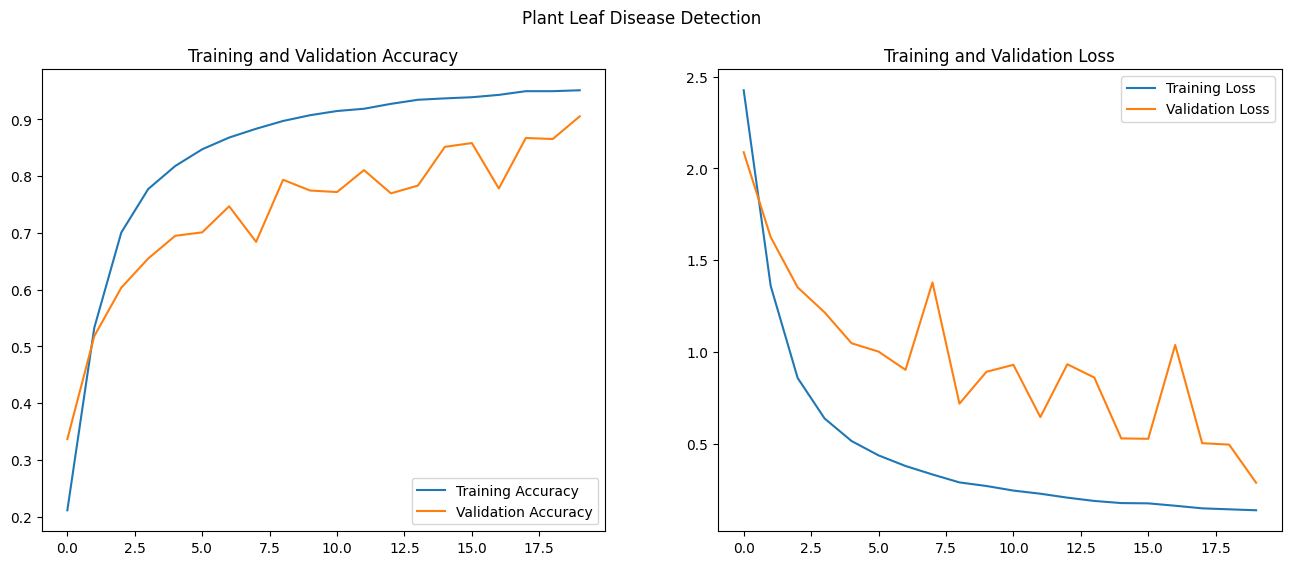

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize = (16, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.suptitle('Plant Leaf Disease Detection')

plt.savefig('plots/acc_and_loss.jpg', dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

## Evaluation

### Evaluating Test data

In [7]:
test_pred = np.argmax(model.predict(test_image_data), axis = 1)
test_pred

NameError: name 'model' is not defined

In [8]:
test_pred_classes = [class_name_lookup[i] for i in test_pred]

pd.DataFrame({
    "Filename": test_image_filenames,
    "Predicted classes": test_pred_classes
    })

NameError: name 'test_pred' is not defined

### Visualizing test data predictions

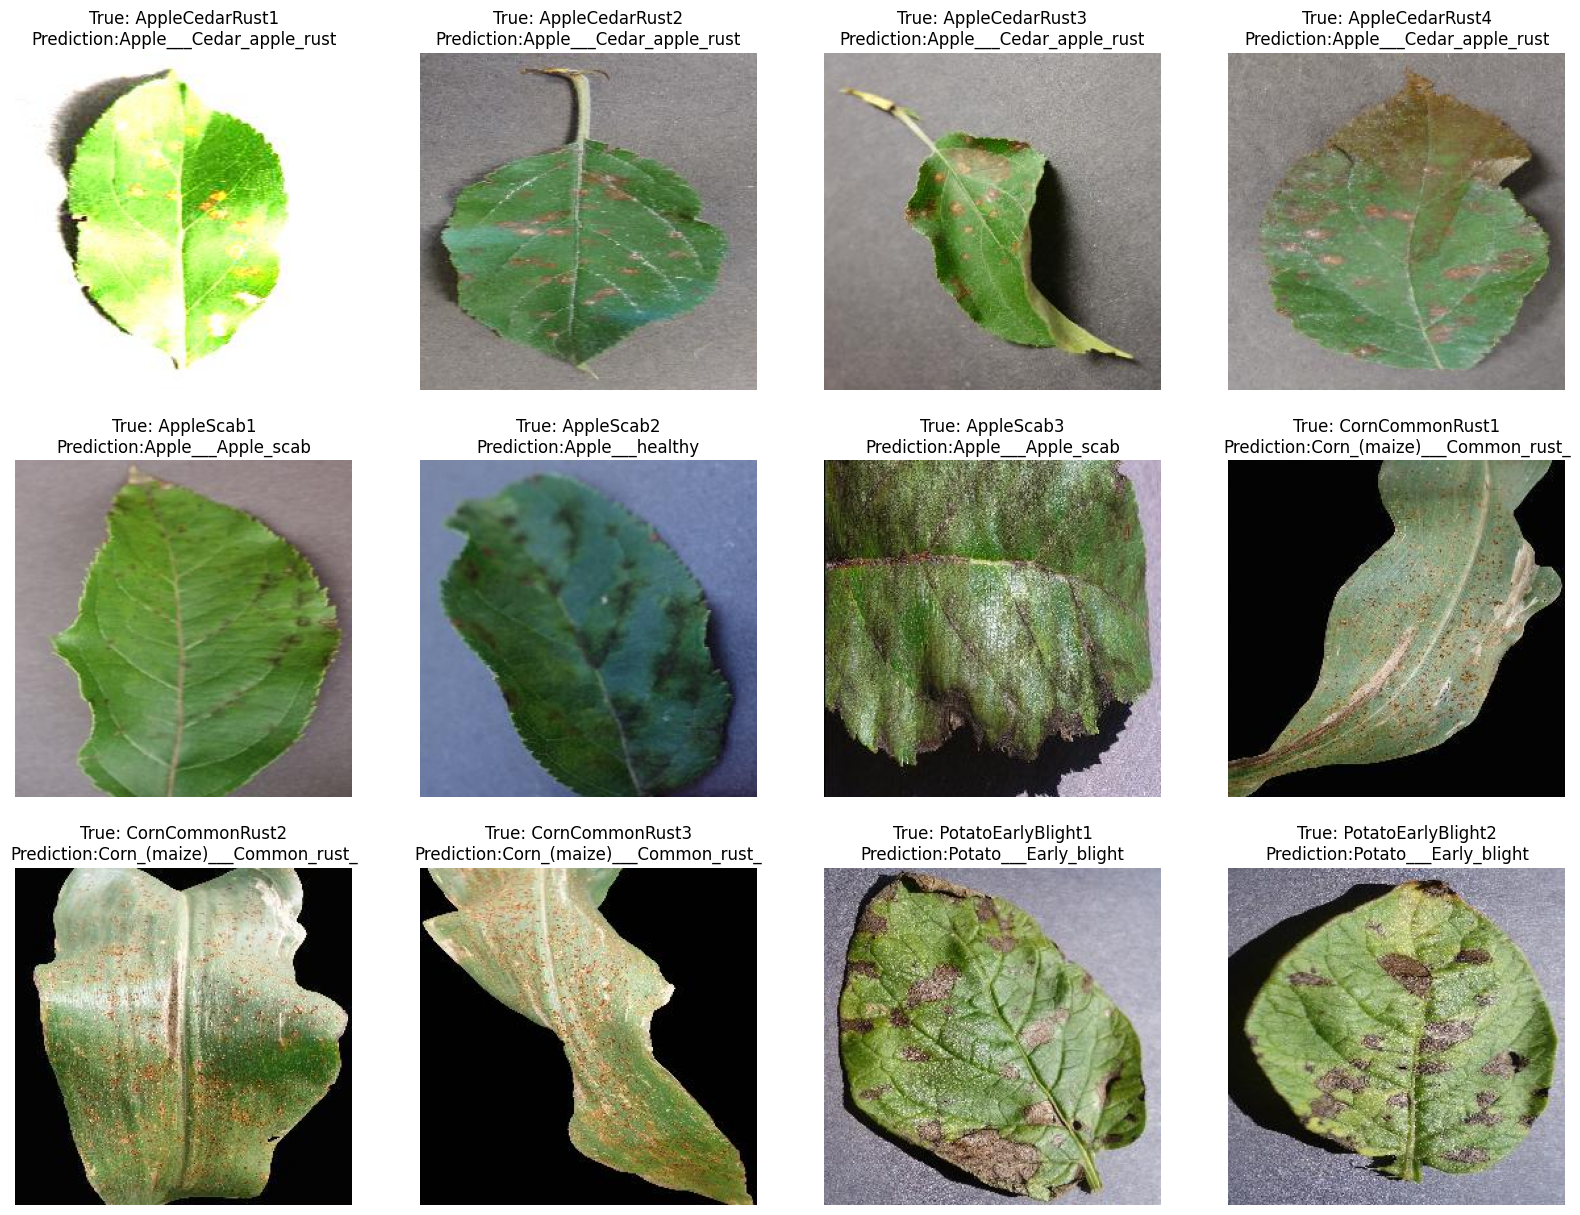

In [52]:
plt.subplots(nrows = 3, ncols = 4, figsize = (20, 15))

for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.imshow(test_image_data[i])
    plt.title(f"True: {test_image_filenames[i][:-4]}\nPrediction:{test_pred_classes[i]}")

plt.show()

### Confusion matrix for validation data

In [53]:
evaluation_data_gen = val_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = VAL_DIR,
        shuffle = False,
        target_size = IMG_SHAPE
    )

Found 8410 images belonging to 18 classes.


132/132 [==============================] - 187s 1s/step


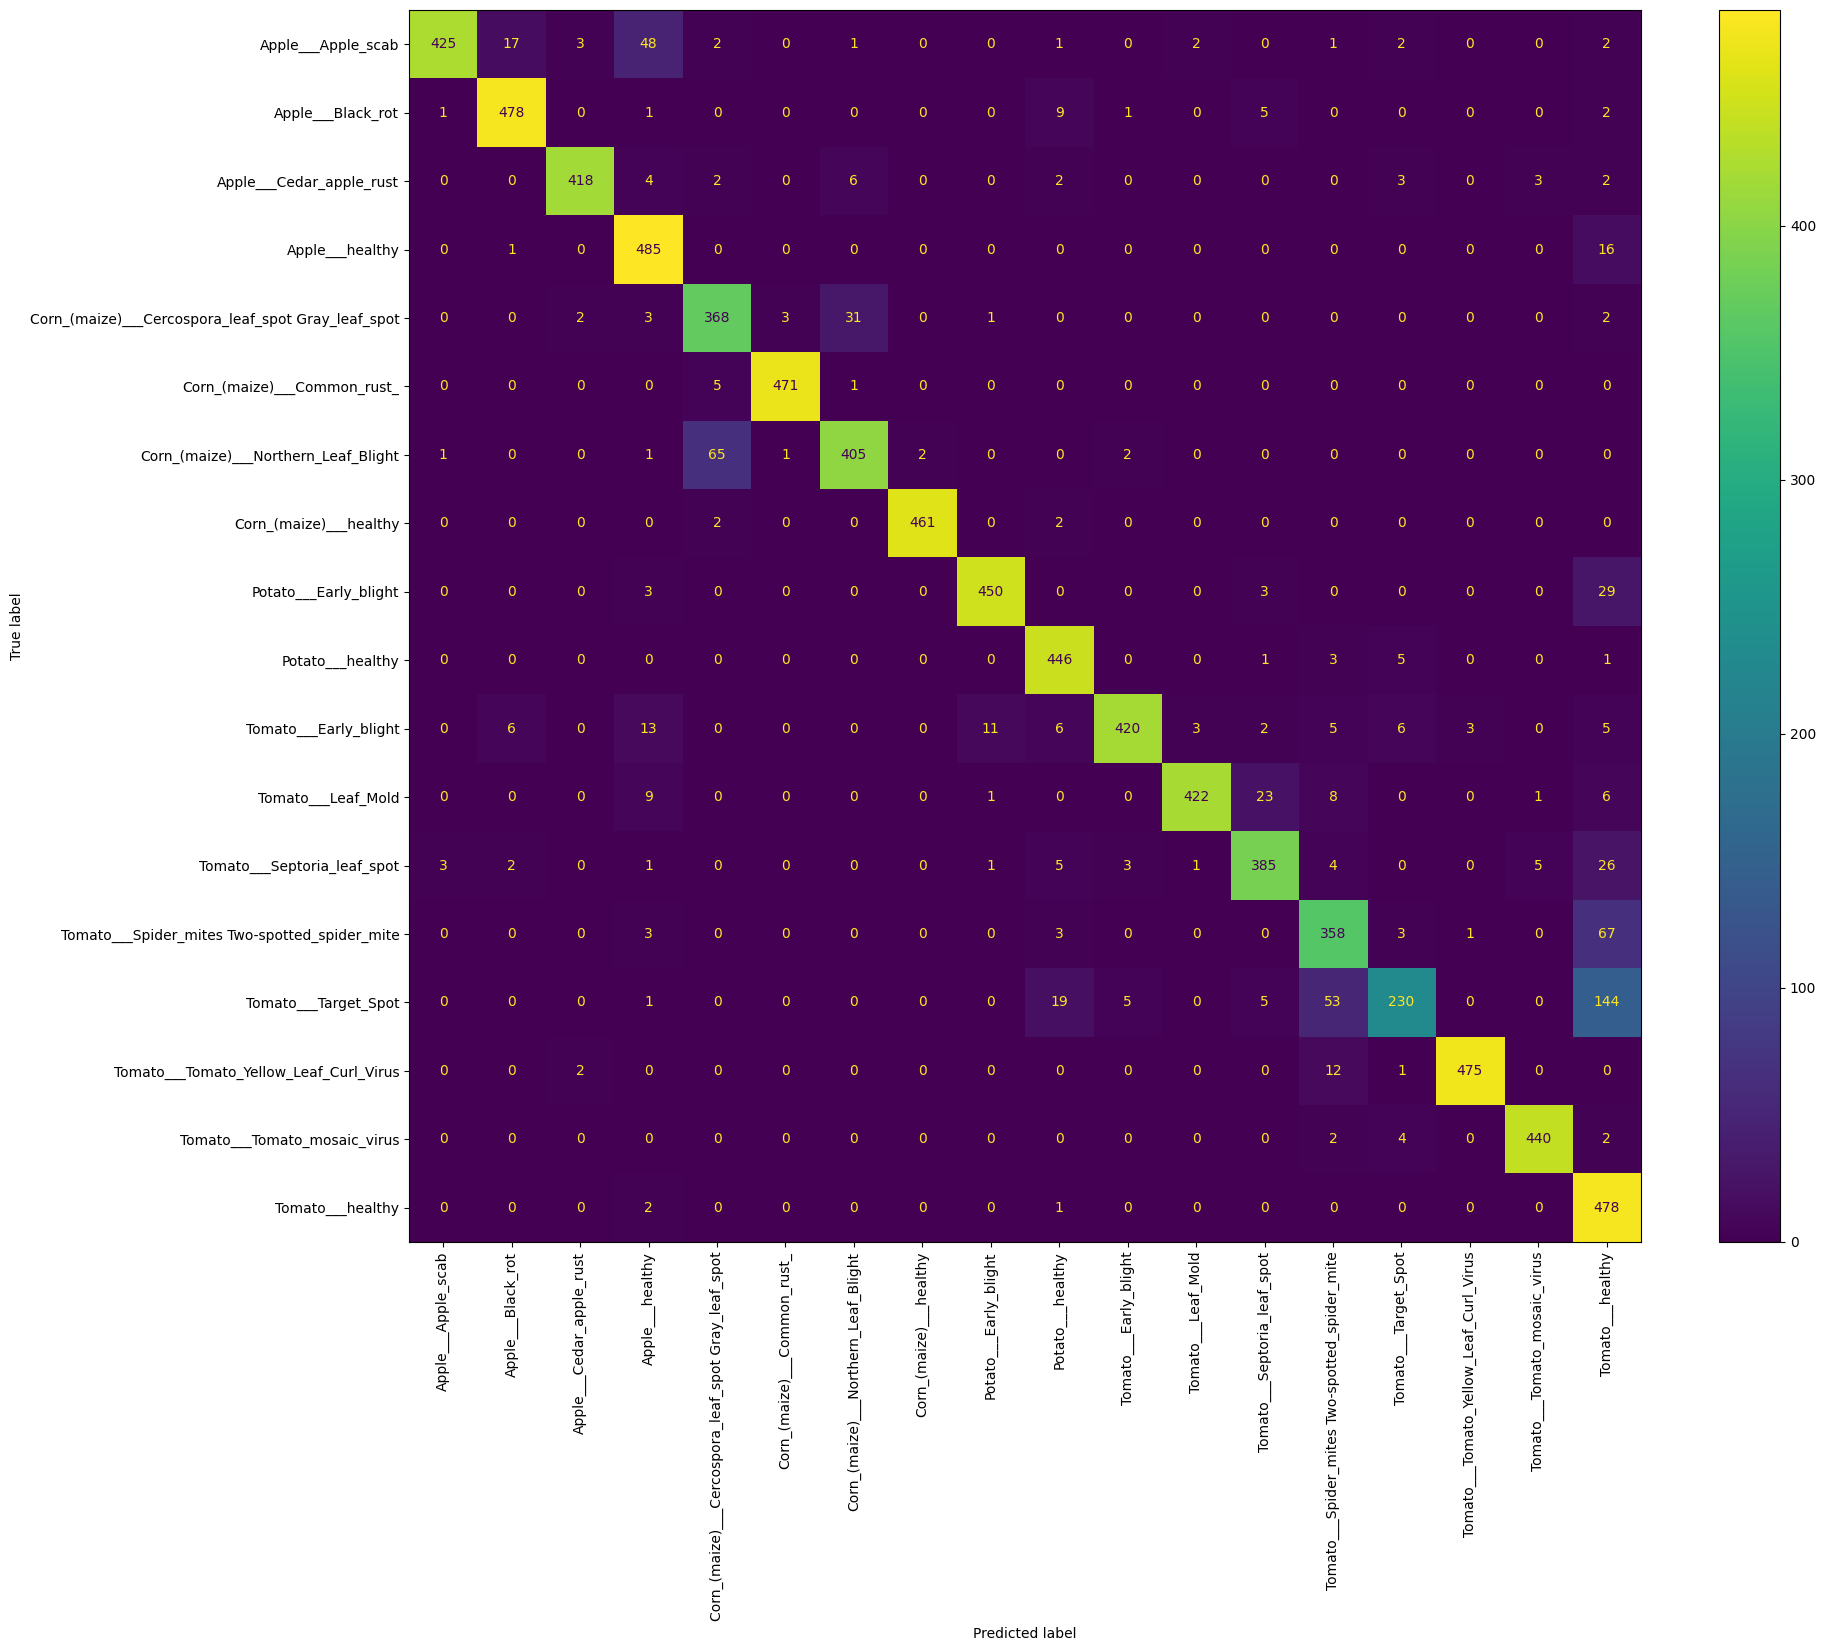

In [54]:
val_true = evaluation_data_gen.classes
val_pred = np.argmax(model.predict(evaluation_data_gen), axis = 1)

_, ax = plt.subplots(figsize = (20, 16))

ConfusionMatrixDisplay(confusion_matrix(val_true, val_pred, labels = list(class_name_lookup.keys())),
                        display_labels = list(class_name_lookup.values())
                        ).plot(ax = ax, xticks_rotation = 'vertical')
                        
plt.savefig('plots/confusion_matrix.jpg', dpi = PLOTS_DPI, bbox_inches = 'tight')
plt.show()

## Saving the model

In [55]:
model.save('models/plant_leaf_disease_detector.h5')